In [21]:
import pandas as pd
import numpy as np
from pathlib import Path
import os,gc

from sklearn.datasets import load_iris
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from pydotplus import graph_from_dot_data
from IPython.display import Image

In [76]:
# ログのライブラリ
import logging
from logging import getLogger, StreamHandler, Formatter

# --------------------------------
# 1.loggerの設定
# --------------------------------
# loggerオブジェクトの宣言
logger = None
stream_handler = None
logger = getLogger("LogTest")

# loggerのログレベル設定(ハンドラに渡すエラーメッセージのレベル)
logger.setLevel(logging.DEBUG)

# --------------------------------
# 2.handlerの設定
# --------------------------------
# handlerの生成
stream_handler = StreamHandler()

# handlerのログレベル設定(ハンドラが出力するエラーメッセージのレベル)
stream_handler.setLevel(logging.DEBUG)

# ログ出力フォーマット設定
handler_format = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(handler_format)

# --------------------------------
# 3.loggerにhandlerをセット
# --------------------------------
logger.addHandler(stream_handler)

# --------------------------------
# ログ出力テスト
# --------------------------------
logger.info("Hello World!")



2019-07-13 19:37:42,235 - LogTest - INFO - Hello World!


# settings

In [24]:
d_home = Path('../')
d_output = d_home/'output'

# udf

In [77]:
def visualizeTreeStructure(decision_tree,feature_names=None):
    '''return text data'''
    
    # retrieve decision tree structure information
    txt = ''
    n_nodes = decision_tree.tree_.node_count
    children_left = decision_tree.tree_.children_left
    children_right = decision_tree.tree_.children_right
    feature = decision_tree.tree_.feature
    threshold = decision_tree.tree_.threshold
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    
    # define each node is leaf or not
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    txt += "The binary tree structure has {} nodes and has the following tree structure:".format(n_nodes) 
    for i in range(n_nodes):
        if is_leaves[i]:
            txt += "\n{}node={} leaf node.".format(node_depth[i] * "\t", i)
        else:
            if feature_names is None:
                txt+= "\n{}node={} test node: go to node {} if X[{:.0f}] <= {} else to node {}.".format(node_depth[i] * "\t",
                         i,
                         children_left[i],
                         feature[i],
                         threshold[i],
                         children_right[i],
                         )
            else:
                txt+= "\n{}node={} test node: go to node {} if {} <= {} else to node {}.".format(node_depth[i] * "\t",
                         i,
                         children_left[i],
                         feature_names[feature[i]],
                         threshold[i],
                         children_right[i],
                         )
    return txt

def extractDecisionInfo(decision_tree,X_train,feature_names=None):
    # extract info from decision_tree
    n_nodes = decision_tree.tree_.node_count
    children_left = decision_tree.tree_.children_left
    children_right = decision_tree.tree_.children_right
    feature = decision_tree.tree_.feature
    threshold = decision_tree.tree_.threshold
    
    df = pd.DataFrame(X_train)
    if feature_names is not None:
        df.columns = feature_names
    
    # indexes with unique nodes
    idx_list = df.assign(
        leaf_id = lambda df: decision_tree.apply(df)
    )[['leaf_id']].drop_duplicates().index

    # test data for unique nodes
    X_test = df.loc[idx_list,feature_names].to_numpy()
    # nodes information for each data
    node_indicator = decision_tree.decision_path(X_test)
    # final leaves for each data
    leave_id = decision_tree.apply(X_test)
    # values for each data
    leave_value = decision_tree.predict(X_test)
    
    # initialize
    n_cols = len(feature_names)
    df_thr_all = pd.DataFrame()

    # Now, it's possible to get the tests that were used to predict a sample or
    # a group of samples. First, let's make it for the sample.
    for sample_id in range(len(idx_list)):
        l_thresh_max = np.ones(n_cols) * np.nan
        l_thresh_min = np.ones(n_cols) * np.nan
    # sample_id = 0
        node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                            node_indicator.indptr[sample_id + 1]]
        
#         print('--Rules used to predict sample {} (node {}): '.format(idx_list[sample_id],leave_id[sample_id]))
        logger.debug('--Rules used to predict sample {} (node {}): '.format(idx_list[sample_id],leave_id[sample_id]))
        for node_id in node_index:
            if leave_id[sample_id] == node_id:
                continue

            if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
                threshold_sign = "<="
                l_thresh_max[feature[node_id]] = threshold[node_id]
            else:
                threshold_sign = ">"
                l_thresh_min[feature[node_id]] = threshold[node_id]

            logger.debug("decision id node {} : ({} (= {}) {} {})".format(node_id,
                     feature_names[feature[node_id]],
                     X_test[sample_id, feature[node_id]],
                     threshold_sign,
                     threshold[node_id]))
        print()
    #     # For a group of samples, we have the following common node.
    #     sample_ids = [0, 1]
    #     common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
    #                     len(sample_ids))

    #     common_node_id = np.arange(n_nodes)[common_nodes]
        # append info to df_thr_all
        df_thr_all = df_thr_all.append(
            [[(thr_min,thr_max) for thr_max,thr_min in zip(l_thresh_max,l_thresh_min)] + [leave_id[sample_id],leave_value[sample_id]]]
        )

    df_thr_all.columns = feature_names + ['node','value']
    df_thr_all.index = idx_list
    
    return df_thr_all

# load iris dataset

In [5]:
iris = load_iris()
dtc = DecisionTreeClassifier(max_depth=5,min_samples_leaf=10)
dtc.fit(iris['data'],iris['target'])
# df_iris.head()

In [7]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [13]:
print(iris['feature_names'])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [39]:
dtc = DecisionTreeClassifier(max_depth=5,min_samples_leaf=10)
dtc.fit(iris['data'],iris['target'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

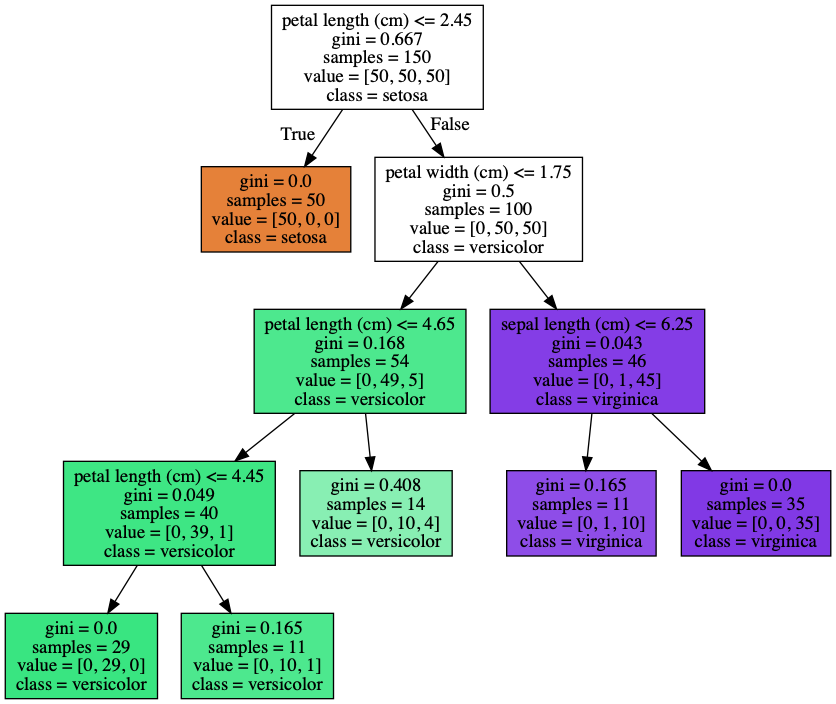

In [40]:
output = d_output/'output_with_graphviz.png'

dotdata = export_graphviz(
    decision_tree=dtc,
    class_names=iris['target_names'],
    feature_names=iris['feature_names'],
    filled=True
)
graph = graph_from_dot_data(dotdata,)
graph.write_png(path=output.as_posix())
Image(graph.create_png())

In [28]:
d_output/'output_with_graphviz.png'

PosixPath('../output/output_with_graphviz.png')

In [66]:
print(visualizeTreeStructure(dtc,feature_names=iris['feature_names']))

The binary tree structure has 11 nodes and has the following tree structure:
node=0 test node: go to node 1 if petal length (cm) <= 2.449999988079071 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if petal width (cm) <= 1.75 else to node 8.
		node=3 test node: go to node 4 if petal length (cm) <= 4.6499998569488525 else to node 7.
			node=4 test node: go to node 5 if petal length (cm) <= 4.450000047683716 else to node 6.
				node=5 leaf node.
				node=6 leaf node.
			node=7 leaf node.
		node=8 test node: go to node 9 if sepal length (cm) <= 6.25 else to node 10.
			node=9 leaf node.
			node=10 leaf node.


In [67]:
print(visualizeTreeStructure(dtc))

The binary tree structure has 11 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[2] <= 2.449999988079071 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[3] <= 1.75 else to node 8.
		node=3 test node: go to node 4 if X[2] <= 4.6499998569488525 else to node 7.
			node=4 test node: go to node 5 if X[2] <= 4.450000047683716 else to node 6.
				node=5 leaf node.
				node=6 leaf node.
			node=7 leaf node.
		node=8 test node: go to node 9 if X[0] <= 6.25 else to node 10.
			node=9 leaf node.
			node=10 leaf node.


In [112]:
dtc.tree_.value[0]

array([[50., 50., 50.]])

In [78]:
extractDecisionInfo(dtc,iris['data'],iris['feature_names'])

2019-07-13 19:37:58,379 - LogTest - DEBUG - --Rules used to predict sample 0 (node 1): 
2019-07-13 19:37:58,389 - LogTest - DEBUG - decision id node 0 : (petal length (cm) (= 1.4) <= 2.449999988079071)
2019-07-13 19:37:58,393 - LogTest - DEBUG - --Rules used to predict sample 50 (node 7): 
2019-07-13 19:37:58,395 - LogTest - DEBUG - decision id node 0 : (petal length (cm) (= 4.7) > 2.449999988079071)
2019-07-13 19:37:58,398 - LogTest - DEBUG - decision id node 2 : (petal width (cm) (= 1.4) <= 1.75)
2019-07-13 19:37:58,402 - LogTest - DEBUG - decision id node 3 : (petal length (cm) (= 4.7) > 4.6499998569488525)
2019-07-13 19:37:58,410 - LogTest - DEBUG - --Rules used to predict sample 51 (node 6): 
2019-07-13 19:37:58,413 - LogTest - DEBUG - decision id node 0 : (petal length (cm) (= 4.5) > 2.449999988079071)
2019-07-13 19:37:58,415 - LogTest - DEBUG - decision id node 2 : (petal width (cm) (= 1.5) <= 1.75)
2019-07-13 19:37:58,418 - LogTest - DEBUG - decision id node 3 : (petal length (

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),node,value
0,"(nan, nan)","(nan, nan)","(nan, 2.449999988079071)","(nan, nan)",1,0
50,"(nan, nan)","(nan, nan)","(4.6499998569488525, nan)","(nan, 1.75)",7,1
51,"(nan, nan)","(nan, nan)","(4.450000047683716, 4.6499998569488525)","(nan, 1.75)",6,1
53,"(nan, nan)","(nan, nan)","(2.449999988079071, 4.450000047683716)","(nan, 1.75)",5,1
70,"(nan, 6.25)","(nan, nan)","(2.449999988079071, nan)","(1.75, nan)",9,2
100,"(6.25, nan)","(nan, nan)","(2.449999988079071, nan)","(1.75, nan)",10,2


In [75]:
dtc.predict(iris['data'])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [132]:
import numpy as np
import pandas as pd

def extractDecisionInfo(decision_tree,X_train,feature_names=None):
    '''return dataframe with node info
    '''
    
    # extract info from decision_tree
    n_nodes = decision_tree.tree_.node_count
    children_left = decision_tree.tree_.children_left
    children_right = decision_tree.tree_.children_right
    feature = decision_tree.tree_.feature
    threshold = decision_tree.tree_.threshold
    impurity = decision_tree.tree_.impurity
    value = decision_tree.tree_.value
    n_node_samples = decision_tree.tree_.n_node_samples
    
    
    df = pd.DataFrame(X_train)
    if feature_names is not None:
        df.columns = feature_names
    
    # indexes with unique nodes
    idx_list = df.assign(
        leaf_id = lambda df: decision_tree.apply(df)
    )[['leaf_id']].drop_duplicates().index

    # test data for unique nodes
    X_test = df.loc[idx_list,].to_numpy()
    # nodes information for each data
    node_indicator = decision_tree.decision_path(X_test)
    # final leaves for each data
    leave_id = decision_tree.apply(X_test)
    # values for each data
    leave_predict = decision_tree.predict(X_test)
    
    # initialize
    n_cols = df.shape[-1]
    df_thr_all = pd.DataFrame()

    # predict for samples
    for sample_id in range(len(idx_list)):
        l_thresh_max = np.ones(n_cols) * np.nan
        l_thresh_min = np.ones(n_cols) * np.nan
        node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                            node_indicator.indptr[sample_id + 1]]
        
        # decision path info for each node
        for node_id in node_index:
            if leave_id[sample_id] == node_id:
                continue

            if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
                l_thresh_max[feature[node_id]] = threshold[node_id]
            else:
                l_thresh_min[feature[node_id]] = threshold[node_id]

        # append info to df_thr_all
        df_thr_all = df_thr_all.append(
            [[(thr_min,thr_max) for thr_max,thr_min in zip(l_thresh_max,l_thresh_min)]
             + [
                 leave_id[sample_id],
                 leave_predict[sample_id],
                 value[leave_id[sample_id]],
                 impurity[leave_id[sample_id]],
                 n_node_samples[leave_id[sample_id]]
               ]
            ]
        )

    # rename columns and set index
    if feature_names is not None:
        df_thr_all.columns = feature_names + ['node','predicted_value','value','impurity','n_node_samples']
    else:
        df_thr_all.columns = ['X_{}'.format(i) for i in range(n_cols)] + ['node','predicted_value','value','impurity','n_node_samples']
    df_thr_all = df_thr_all.set_index('node')
    
    return df_thr_all

In [134]:
print(extractDecisionInfo(dtc,iris['data'],feature_names=iris['feature_names']))

     sepal length (cm) sepal width (cm)  \
node                                      
1           (nan, nan)       (nan, nan)   
7           (nan, nan)       (nan, nan)   
6           (nan, nan)       (nan, nan)   
5           (nan, nan)       (nan, nan)   
9          (nan, 6.25)       (nan, nan)   
10         (6.25, nan)       (nan, nan)   

                            petal length (cm) petal width (cm)  \
node                                                             
1                    (nan, 2.449999988079071)       (nan, nan)   
7                   (4.6499998569488525, nan)      (nan, 1.75)   
6     (4.450000047683716, 4.6499998569488525)      (nan, 1.75)   
5      (2.449999988079071, 4.450000047683716)      (nan, 1.75)   
9                    (2.449999988079071, nan)      (1.75, nan)   
10                   (2.449999988079071, nan)      (1.75, nan)   

      predicted_value               value  impurity  n_node_samples  
node                                                    

In [137]:
dp = dtc.decision_path(iris['data'])
dp.indptr[2]

4

In [150]:
sid = 120
dp.indices[dp.indptr[sid]:dp.indptr[sid+1]]

array([ 0,  2,  8, 10], dtype=int32)